In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10
batch_size = 128
num_epochs = 20

Files already downloaded and verified
Files already downloaded and verified
Тренировочные данные:


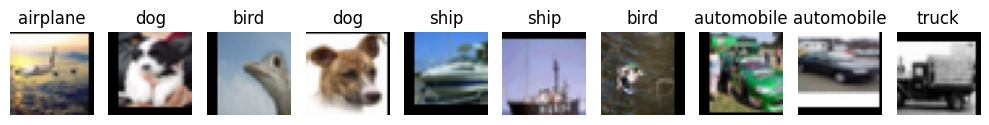

Тестовые данные:


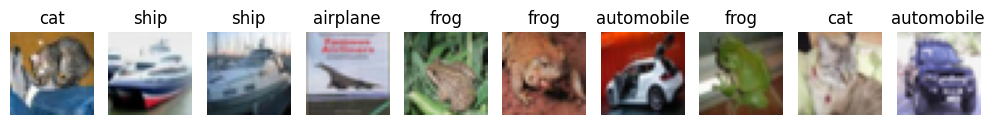

Размерность x_train: (50000, 32, 32, 3)
Размерность y_train: 50000
Размерность x_test: (10000, 32, 32, 3)
Размерность y_test: 10000


In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_data(loader, title):
    print(f"{title}:")
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 10, figsize=(10, 5))
    for ax, image, label in zip(axes, images, labels):
        image = image.permute(1, 2, 0)
        image = image * torch.tensor((0.2023, 0.1994, 0.2010)) + torch.tensor((0.4914, 0.4822, 0.4465))
        image = image.clamp(0, 1)
        ax.set_title(classes[label])
        ax.imshow(image)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_data(train_loader, "Тренировочные данные")
visualize_data(test_loader, "Тестовые данные")

print(f"Размерность x_train: {train_dataset.data.shape}")
print(f"Размерность y_train: {len(train_dataset.targets)}")
print(f"Размерность x_test: {test_dataset.data.shape}")
print(f"Размерность y_test: {len(test_dataset.targets)}")

In [4]:
models_names = ['resnet18', 'resnet50', 'densenet201', 'mobilenet_v2']
models_to_train = [
    models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1),
    models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
    models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1),
    models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
]

In [5]:
criterion = nn.CrossEntropyLoss()

history = {}
best_model = None
best_accuracy = 0

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    train_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Оценка модели
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {test_accuracy:.4f}')

    return train_losses, test_accuracies

In [6]:
def run_experiment(do_fine_tuning, models_names, num_epochs, history):
    prefix = "FineTuning_" if do_fine_tuning else "FeatureExtraction_"
    global best_accuracy
    global best_model 
    local_best_accuracy = 0
    local_best_model = None

    for model_name, model in zip(models_names, models_to_train):
        prefixed_model_name = prefix + model_name
        
        model = getattr(models, model_name)(weights=models.ResNet18_Weights.IMAGENET1K_V1 if 'resnet18' in model_name else 
                                            models.ResNet50_Weights.IMAGENET1K_V1 if 'resnet50' in model_name else 
                                            models.DenseNet201_Weights.IMAGENET1K_V1 if 'densenet201' in model_name else 
                                            models.MobileNet_V2_Weights.IMAGENET1K_V1).to(device)

        for param in model.parameters():
            param.requires_grad = do_fine_tuning

        if 'resnet' in model_name:
            num_ftrs = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Linear(num_ftrs, num_ftrs//2),
                nn.ReLU(),
                nn.Linear(num_ftrs//2, 10),
            )
        elif 'densenet' in model_name:
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Sequential(
                nn.Linear(num_ftrs, num_ftrs//2),
                nn.ReLU(),
                nn.Linear(num_ftrs//2, 10),
            )
        elif 'mobilenet_v2' in model_name:
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Sequential(
                nn.Linear(num_ftrs, num_ftrs//2),
                nn.ReLU(),
                nn.Linear(num_ftrs//2, 10),
            )
        else:
            raise ValueError(f"Model {model_name} is not supported")

        model = model.to(device)
        print(f"Модель {prefixed_model_name}:")
        print(model)

        print(f"\nМодель {prefixed_model_name}:")
        print("Инициализация: с предобученными весами")
        print(f"Тип обучения: {'Дообучение всех слоев' if do_fine_tuning else 'Извлечение признаков'}")
        print("Модифицированные слои:")
        if 'resnet' in model_name:
            print(model.fc)
        elif 'mobilenet_v2' in model_name:
            print(model.classifier[1])
        elif 'densenet' in model_name:
            print(model.classifier)
        
        # Обучение и тестирование модели
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
        print(f"Параметры обучения: оптимизатор Adam с lr={optimizer.param_groups[0]['lr']}")
        train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
        history[prefixed_model_name] = (train_losses, test_accuracies)
        print("\n\n\n")

        final_accuracy = test_accuracies[-1]
        if final_accuracy > local_best_accuracy:
            local_best_accuracy = final_accuracy
            local_best_model = prefixed_model_name

    if local_best_accuracy > best_accuracy:
        best_accuracy = local_best_accuracy
        best_model = local_best_model

# Запуск экспериментов
run_experiment(True, models_names, num_epochs, history)
run_experiment(False, models_names, num_epochs, history)

Модель FineTuning_resnet18:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

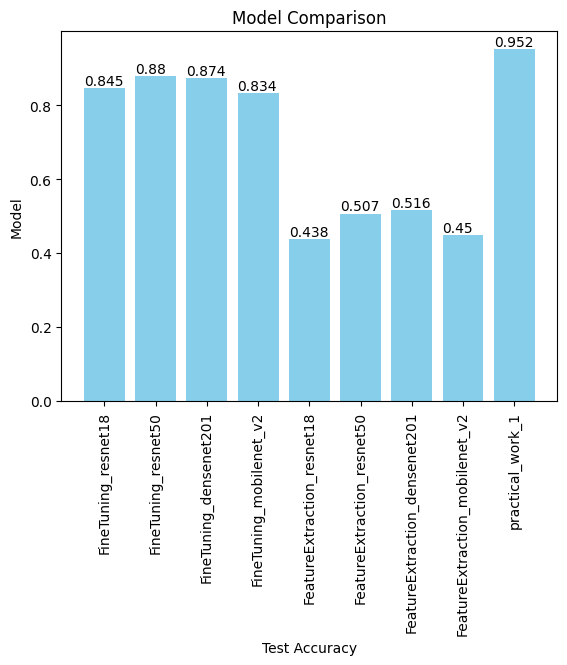

Наиболее эффективная модель: FineTuning_resnet50
Наилучшая точность: 0.8798
Тип эксперимента:  Дообучение
Инициализация: с предобученными весами
Параметры обучения: оптимизатор Adam с lr=0.0001


In [8]:
def compare_models(history):
    final_accuracies = {model_name: values[1][-1] for model_name, values in history.items()}
    final_accuracies['practical_work_1'] = 0.9517

    model_names = list(final_accuracies.keys())
    accuracies = list(final_accuracies.values())
    
    plt.bar(model_names, accuracies, color='skyblue')
    bars = plt.bar(model_names, accuracies, color='skyblue')
    plt.xlabel('Test Accuracy')
    plt.ylabel('Model')
    plt.title('Model Comparison')
    plt.xticks(rotation = 90)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x(), yval, round(yval, 3), va='bottom')
    
    plt.show()

compare_models(history)

print(f"Наиболее эффективная модель: {best_model}")
print(f"Наилучшая точность: {best_accuracy}")
print("Тип эксперимента: ", "Дообучение" if "FineTuning" in best_model else "Извлечение признаков")
print("Инициализация: с предобученными весами")
print("Параметры обучения: оптимизатор Adam с lr=0.0001")